# Taller Fourier EDM - Clasificación de cargas de electrodomésticos

## Práctica 4 - Clasificación de cargas

### Objetivos:
En esta práctica se busca clasificar las cargas en los distintos tipos de electrodomésticos. Partiendo de las señales I y V se extraen características de las cargas y se ensayan varios clasificadores

### Actividades

1. Extracción de características  
A partir de las señales V e I de una carga, se extraen diversas características a usar en la clasificación. 

2. Prueba de distintos clasificadores

3. Evaluación de resultados  
Como se vio en la práctica 2, la base de señales usada tiene señales de diversos tipos de electrodomésticos adquiridas en distintas casas. Para evaluar los resultados de la clasificación se realizará validación cruzada con el esquema "dejar uno afuera". En este esquema se entrena un clasificador con los datos de N-1 casas y se clasifican las señales de la casa restante. Esto se repite para todos los casos y se reportan los resultados de "acierto promedio" y matriz de confusión.


### Materiales

Se usa la base de referencia *PLAID* de señales V-I correspondiente a once tipos distintos de electrodomésticos ('Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine') [1, 2].

Las señales, de 2 a 5 segundos de duración, están en archivos ".csv" donde la primera columna es la intensidad y la segunda columna es el voltaje.  
La frecuencia de línea de las señales es $F_l=60Hz$.  
La frecuencia de muestreo de las señales es $F_s=30kHz$.

[1] Gao, Jingkun, et al. "Plaid: a public dataset of high-resoultion electrical appliance measurements for load identification research: demo abstract." proceedings of the 1st ACM Conference on Embedded Systems for Energy-Efficient Buildings. ACM, 2014.

[2] Medico, Roberto, Leen De Baets, Jingkun Gao, Suman Giri, Emre Kara, Tom Dhaene, Chris Develder, Mario Bergés, and Dirk Deschrijver. "A voltage and current measurement dataset for plug load appliance identification in households." Scientific data 7, no. 1 (2020): 1-10.

### Datos

Usaremos un subset de la base de datos PLAID disponible en EVA.   

El archivo "meta1_simple.csv" en la carpeta "data" tiene tres columnas con la información sobre las señales de los electrodomésticos.   
Columnas:  
* [id]    identificador del electrodoméstico
* [tipo]  tipo del electrodoméstico
* [casa]  identificador de la casa donde se registró la señal

Los electrodomésticos son  [tipo, nombre]:  
* 0: 'Air Conditioner',
* 1: 'Compact Fluorescent Lamp',
* 2: 'Fan',
* 3: 'Fridge',
* 4: 'Hairdryer',
* 5: 'Heater',
* 6: 'Incandescent Light Bulb',
* 7: 'Laptop',
* 8: 'Microwave',
* 9: 'Vacuum',
* 10: 'Washing Machine'

Por ejemplo, las señales I,V en el archivo '10.csv' corresponde al electrodoméstico con id=10, tipo=8 (Microwave) y de la casa=1.

### Uso de funciones de la práctica 2.

En esta práctica usaremos las funciones creadas en la práctica 2.  
Para eso se copiarán las funciones a un archivo **funciones_practica_2.py** dentro 
del directorio **funciones**.  


Para poder usar las funciones se importarán con:  
**from funciones.funciones_practica_2 import * **



### Trabajo a realizar

A lo largo del notebook encontraran las siguientes palabras claves:

* \# COMPLETAR  -> indica que se requiere completar el código. 
  
  
* \# EXPERIMENTAR -> indica que la celda contiene código funcional que permite experimentar variando el tipo de electrodoméstico, parámetros de las funciones, etc. Es posible, si lo requiere la experimentación duplicar la celda y realizar los cambio que sean de interés en el código.
  
  
* \# DISCUTIR -> se espera una discusión de los experimentos realizados y/o de las preguntas formuladas
  
  
  
* \# RESPONDER -> se espera una respuesta a preguntas concretas

In [6]:
import os
import numpy as np
from scipy.fftpack import fft, fftshift, ifft
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import time

# autoreload. Los cambios en modulos externos como 'funciones_practica_1.py' se recargan automaticamente
%load_ext autoreload
%autoreload 2

# importar las funciones de la práctica 2
from funciones.funciones_practica_2 import *

# importar funciones utiles
from funciones.util import plot_confusion_matrix

#estilo de las gráficas
plt.style.use('ggplot')

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
#%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
%matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# importar funciones del módulo de aprendizaje sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as ABC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

## Parte 1 - Carga de los datos

In [8]:
frecuencia_muestreo = 30000 #Frecuencia de muestreo en Hz
frecuencia_linea = 60    #Frecuencia de línea en Hz
muestras_por_ciclo = int(frecuencia_muestreo/frecuencia_linea)

nombres_electrodomesticos = ['Air Conditioner', 
                         'Compact Fluorescent Lamp',
                         'Fan',
                         'Fridge',
                         'Hairdryer',
                         'Heater',
                         'Incandescent Light Bulb',
                         'Laptop',
                         'Microwave',
                         'Vacuum',
                         'Washing Machine']

nombres_abreviados_electrodomesticos = ['AirC','CFL','Fan','Frid','Hair','Heat','ILB','Lapt','MWave','Vacc','Wash']

# ubicación del directorio  de la base PLAID que contiene los ".csv"
PLAID_csv_directory = "./bdd/PLAID/CSV"

# archivo con la metadata
archivo_metadata = './data/meta1_simple.csv'


### 1.1 Testear las funciones de carga de meta-datos

In [9]:
# Testeos. Permite verificar que se cargan bien las funciones de la práctica 2

print('-------------------------------------------------------------') 
# Imprimir la cantidad de electrodomesticos en la base
print('Cantidad de electrodomésticos en la base:', get_cantidad_electrodomesticos() )

print('-------------------------------------------------------------') 
# Imprimir lista de tipos y nombres
for i in range(len(nombres_electrodomesticos)):
    print('{}:{}'.format(i,nombres_electrodomesticos[i]))

    
print('-------------------------------------------------------------') 
# Imprimir datos de un cierto electrodoméstico
id_elec = 10
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))
print('-------------------------------------------------------------')   


print('-------------------------------------------------------------') 
# Imprimir datos de un cierto tipo de electrodomésticos
tipo = np.random.choice(len(nombres_electrodomesticos))
ids = get_ids_por_tipo(tipo)

print('Electrodomésticos tipo {}:{}'.format(tipo, nombres_electrodomesticos[tipo]))
print(ids)

print('Un electrodoméstico de este tipo ---------------')
id_elec = np.random.choice(ids)
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))

print('-------------------------------------------------------------') 
# Imprimir datos de una cierta casa
casa = 17
ids = get_ids_por_casa(casa)

print('Electrodomésticos de la casa {}'.format(casa))
print(ids)



-------------------------------------------------------------
Cantidad de electrodomésticos en la base: 1074
-------------------------------------------------------------
0:Air Conditioner
1:Compact Fluorescent Lamp
2:Fan
3:Fridge
4:Hairdryer
5:Heater
6:Incandescent Light Bulb
7:Laptop
8:Microwave
9:Vacuum
10:Washing Machine
-------------------------------------------------------------
Id electrodoméstico: 10
Archivo: ./bdd/PLAID/CSV/10.csv
Tipo: 8.0:Microwave
Casa: 1.0
-------------------------------------------------------------
-------------------------------------------------------------
Electrodomésticos tipo 8:Microwave
[10, 11, 12, 13, 14, 33, 34, 35, 36, 37, 214, 215, 216, 217, 218, 239, 240, 241, 242, 243, 259, 260, 261, 262, 263, 284, 285, 286, 287, 308, 309, 310, 311, 312, 328, 329, 330, 331, 332, 335, 336, 337, 338, 339, 360, 361, 362, 363, 364, 418, 419, 420, 421, 422, 463, 464, 465, 466, 467, 483, 484, 485, 486, 487, 558, 559, 560, 561, 562, 585, 586, 587, 588, 589, 605, 

## Parte 2. Extracción de características

### 2.1 Calcular las características  dadas por la función **calcular_potencia_IEEE_1459_2010** para todos los electrodomésticos.  

Se usarán los datos de régimen descartando el inicio de las señales que contiene el  transitorio de arranque. El transitorio es variable en la base dependiendo del electrodoméstico y de la adquisición particular. Para la práctica pueden considerar que el transitorio dura un largo fijo para todas las señales ( algo entre 0.25 segundos (15 ciclos) y 1 segundo (60 ciclos) ) que determinaran por inspección de las señales). 

Se obtendrán tres arrays:
* **DATOS_IEEE** de tamaño **[cant_electrodomesticos x 14]**
* **TIPO** de tamaño **[cant_electrodomesticos x 1]** con el tipo (numérico) de cada electrodoméstico de la base
* **CASA** de tamaño **[cant_electrodomesticos x 1]** con la casa correspondiente a cada electrodoméstico de la base


Cada fila del array **DATOS_IEEE** son 14 características **[S, S_11, S_H, S_N, P, P_11, P_H, Q_11, D_I, D_V, D_H, N, THD_V, THD_I]** que hemos calculado a partir de las señales I,V de un electrodoméstico. 

Los elementos del array **TIPO** representan la etiqueta "real" de cada electrodoméstico. 

Los elementos del array **CASA** indican los subconjuntos en los que se agrupan los electrodomésticos.

Con las etiquetas, las características calculadas y la información de subconjuntos entrenaremos nuestros clasificadores y también evaluaremos la performance de los mismos.


In [10]:
# COMPLETAR
# Calcular las características dadas por la
# función calcular_potencia_IEEE_1459_2010 

#Cant_electrodomesticox14 ya que le pasamos una base PLAID y por cada uno la def de potencia devuelve 14 resultados
#cantidad_electr no necesitaba parametros, ya tenia asociada la base plaid

cant_electrodomesticos=get_cantidad_electrodomesticos()
DATOS_IEEE=np.zeros(shape=(cant_electrodomesticos,1))
TIPO=np.zeros(shape=(cant_electrodomesticos))


ids = get_ids()

# inicializar arrays
TIPO=np.empty( (cant_electrodomesticos), dtype=np.uint8)
CASA = np.empty( (cant_electrodomesticos), dtype=np.uint8)
DATOS_IEEE = np.zeros((cant_electrodomesticos, 14))

for i in range(0,len(ids)):
    id_elec = ids[i]          
    print('Calculando {:04d}/{:04d}'.format(id_elec, cant_electrodomesticos), end='\r', flush=True)
    
    I,V=cargar_VI_por_ciclos_optimizado(get_nombre_archivo(i+1),frecuencia_muestreo=30000,frecuencia_linea=60,ciclos_a_cargar=1e100,ciclos_a_saltear=0)
    DATOS_IEEE[i] = np.array(calcular_potencia_IEEE_1459_2010(I,V, frecuencia_muestreo=30000, frecuencia_linea=60), dtype=np.float64)
    TIPO[i]= get_tipo(i+1)
    CASA[i]= get_casa(i+1)

    print('\n')
    print('DATOS_IEEE', DATOS_IEEE)
    print('TIPO', TIPO[i])
    print('CASA', CASA[i])
    
    
    #COMPLETAR código


Calculando 0000/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 1
Calculando 0001/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 1
Calculando 0002/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0018/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 2
Calculando 0019/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 2
Calculando 0020/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0036/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 2
Calculando 0037/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 3
Calculando 0038/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0054/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 9
CASA 3
Calculando 0055/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 9
CASA 3
Calculando 0056/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0072/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 4
Calculando 0073/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 4
Calculando 0074/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0090/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 6
Calculando 0091/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 6
Calculando 0092/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0108/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 6
Calculando 0109/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 6
Calculando 0110/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0126/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 7
Calculando 0127/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 7
Calculando 0128/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0144/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 7
Calculando 0145/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 8
Calculando 0146/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0162/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 9
Calculando 0163/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 9
Calculando 0164/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0180/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 9
Calculando 0181/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 9
Calculando 0182/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9

Calculando 0198/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 3
CASA 10
Calculando 0199/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 10
Calculando 0200/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0216/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 10
Calculando 0217/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 10
Calculando 0218/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0234/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 11
Calculando 0235/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 11
Calculando 0236/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0252/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 12
Calculando 0253/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 12
Calculando 0254/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0270/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 13
Calculando 0271/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 13
Calculando 0272/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0288/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 14
Calculando 0289/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 14
Calculando 0290/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0306/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 14
Calculando 0307/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 14
Calculando 0308/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0324/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 15
Calculando 0325/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 15
Calculando 0326/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0342/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 17
Calculando 0343/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 17
Calculando 0344/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0360/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 17
Calculando 0361/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 17
Calculando 0362/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0378/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 19
Calculando 0379/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 19
Calculando 0380/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0396/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 20
Calculando 0397/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 20
Calculando 0398/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0414/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 20
Calculando 0415/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 20
Calculando 0416/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0432/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 21
Calculando 0433/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 21
Calculando 0434/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0450/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 22
Calculando 0451/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 22
Calculando 0452/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0468/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 23
Calculando 0469/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 23
Calculando 0470/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0486/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 23
Calculando 0487/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 10
CASA 23
Calculando 0488/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-0

Calculando 0504/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 24
Calculando 0505/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 24
Calculando 0506/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0522/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 25
Calculando 0523/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 25
Calculando 0524/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0540/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 27
Calculando 0541/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 27
Calculando 0542/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0558/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 27
Calculando 0559/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 27
Calculando 0560/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0576/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 28
Calculando 0577/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 28
Calculando 0578/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0594/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 29
Calculando 0595/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 29
Calculando 0596/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0612/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 30
Calculando 0613/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 30
Calculando 0614/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0630/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 3
CASA 31
Calculando 0631/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 3
CASA 31
Calculando 0632/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0648/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 31
Calculando 0649/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 31
Calculando 0650/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0666/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 32
Calculando 0667/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 32
Calculando 0668/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0684/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 2
CASA 33
Calculando 0685/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 3
CASA 33
Calculando 0686/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0702/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 34
Calculando 0703/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 34
Calculando 0704/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0720/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 34
Calculando 0721/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 34
Calculando 0722/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0738/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 36
Calculando 0739/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 36
Calculando 0740/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0756/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 37
Calculando 0757/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 37
Calculando 0758/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0774/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 38
Calculando 0775/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 38
Calculando 0776/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0792/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 39
Calculando 0793/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 39
Calculando 0794/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0810/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 9
CASA 39
Calculando 0811/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 9
CASA 39
Calculando 0812/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0828/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 40
Calculando 0829/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 40
Calculando 0830/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0846/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 41
Calculando 0847/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 41
Calculando 0848/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0864/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 42
Calculando 0865/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 43
Calculando 0866/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0882/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 44
Calculando 0883/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 44
Calculando 0884/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0900/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 44
Calculando 0901/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 8
CASA 44
Calculando 0902/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0918/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 47
Calculando 0919/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 47
Calculando 0920/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0936/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 48
Calculando 0937/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 48
Calculando 0938/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0954/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 49
Calculando 0955/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 49
Calculando 0956/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0972/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 50
Calculando 0973/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 50
Calculando 0974/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 0990/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 51
Calculando 0991/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 1
CASA 51
Calculando 0992/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 1008/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 52
Calculando 1009/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 0
CASA 52
Calculando 1010/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 1026/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 54
Calculando 1027/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 6
CASA 54
Calculando 1028/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 1044/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 54
Calculando 1045/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 7
CASA 54
Calculando 1046/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

Calculando 1062/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 3
CASA 55
Calculando 1063/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02 9.200e-01]
 [3.772e+01 2.830e+01 5.200e-01 ... 3.018e+01 2.000e-02 8.800e-01]
 [3.803e+01 2.914e+01 5.100e-01 ... 3.036e+01 2.000e-02 8.400e-01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
TIPO 4
CASA 55
Calculando 1064/1074

DATOS_IEEE [[4.171e+01 3.064e+01 6.000e-01 ... 3.395e+01 2.000e-02

In [11]:
print(CASA.shape)
print(TIPO)
#print(DATOS_IEEE)
#print(DATOS_IEEE[1073])

(1074,)
[ 1  1  1 ...  7  7 10]


### 2.2 Calcular el factor de potencia fundamental y el factor de potencia total

Estas son otras características derivadas de las calculadas en 2.1  

Se obtendrán dos arrays:
* **FP_fun** de tamaño **[cant_electrodomesticos x 1]**
* **FP_tot** de tamaño **[cant_electrodomesticos x 1]**



In [12]:
# COMPLETAR
# Calcular las características FP_fun y FP_tot

FP_fun = np.empty((len(ids)), np.float64)
FP_tot = np.empty((len(ids)), np.float64)
for i in range(len(ids)):
#for i in range(1,3+1):

    #print('Caso i ',i)
    id_elec = ids[i]          
    #print('Calculando {:04d}/{:04d}'.format(id_elec, len(ids)), end='\r', flush=True)   
    t=time.time()
    #print('DATOSIEEE',time.time()-t)
    
    t=time.time()
    FP_fun[i] = DATOS_IEEE[i][5]/DATOS_IEEE[i][1]
    FP_tot[i] = DATOS_IEEE[i][4]/DATOS_IEEE[i][0]
    if np.isnan(FP_fun[i]):
        print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        print("FP_fun[i]", FP_fun[i])
        print('Caso i ',i)
        print(DATOS_IEEE[i])
    if np.isnan(FP_tot[i]):
        print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        print("FP_tot[i]", FP_tot[i])
        print('Caso i ',i)
        print(DATOS_IEEE[i][4])
    #print('FP',time.time()-t)
    #prints
    
    #print(DATOS_IEEE[i])
    '''
    print(FP_fun)
    print(FP_tot)
    print('\n')

    '''



In [13]:
import sys
np.set_printoptions(threshold=3)
print(FP_fun.shape)
print(np.isnan(FP_fun))

(1074,)
[False False False ... False False False]


### 2.3 Analizar características: realizar histogramas y box-plot de las características

Elegir tres características de las 16 que se han calculado al momento y realizar histogramas y/o box-plot de las mismas.

<IPython.core.display.Javascript object>


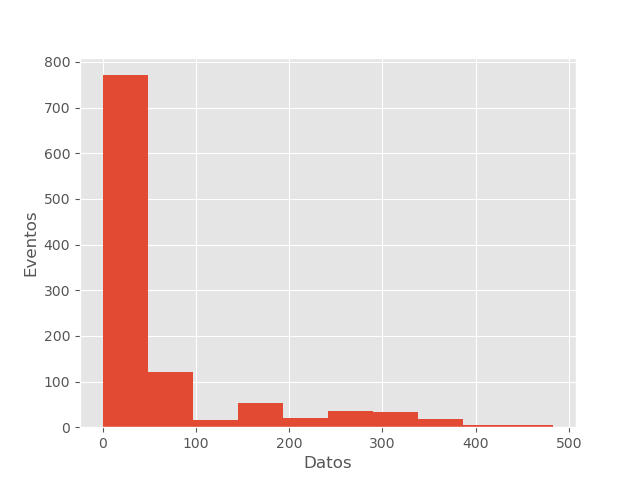

In [57]:
# COMPLETAR
# Histogramas y/o box-plot


#HISTOGRAMA CON LAS POTENCIAS

import numpy as np
import matplotlib.pyplot as plt

#nuestro data van a ser todas las potencias q elijamos
data1=DATOS_IEEE[3,1]
for i in (2,1074):
    data1=np.concatenate((DATOS_IEEE[:,3], DATOS_IEEE[:+1,3]))
    


    

(counts, bins, patches) = plt.hist(data1)
plt.xlabel("Datos")
plt.ylabel("Eventos")
plt.show()



## Parte 3. Clasificación. Entrenamiento y validación cruzada


### 3.1 Entrenamiento y validación cruzada

Como se vio en la práctica 2, la base de señales usada tiene señales de diversos tipos de electrodomésticos adquiridas en distintas casas (N=55 casas). Para entrenar y evaluar los resultados de la clasificación se realizará validación cruzada con el esquema "dejar uno afuera". En este esquema se entrena un clasificador con los datos de N-1 casas y se clasifican las señales de la casa restante. Esto se repite para todos los casos y se reportan los resultados de "acierto promedio" y matriz de confusión.

La función **clasificar** recibe
* un clasificador, 
* las características a utilizar, 
* las etiquetas,
* los indicadores de subconjunto o "fold" en que se agrupan los datos.

En nuestro caso, 
* Como clasificador se usará alguno de los disponibles en sklearn (K vecinos más cercanos, Random Forest, etc.)
* Las características serán algunas de las calculadas en la parte 2 que se pasarán en un array de tamaño  **[cant_electrodomésticos x cant_características]**  
* Las etiquetas serán los tipos de los electrodomésticos en un array de tamaño **[cant_electrodomesticos x 1]**
* Los indicadores de subconjunto serán las casas a las que pertenecen los electrodomésticos como un array de tamaño **[cant_electrodomesticos x 1]**

In [15]:
# COMPLETAR
# Comentar adecuadamente el código  
# No es necesario modificar el código 

def clasificar(clasificador, caracteristicas, etiquetas, subconjuntos ):
    '''
    Recibe un clasificador ya creado, las caracteristicas, 
    las etiquetas y los indicadores de subconjuntos. 
    Devuelve las tasas de acierto y las predicciones
    '''
    
    # Si se usa una sóla característica, forzar que sea un vector columna
    if caracteristicas.ndim == 1:
        caracteristicas = caracteristicas[:,np.newaxis]
    
    # calcula la cantidad de subconjuntos (por ejemplo, casas) distintas usando la funcion unique
    cantidad_subconjuntos = len(np.unique(subconjuntos))
    
    # prepara dos arrays vacios, uno el cual guardara los aciertos, y el otro que guardara las predicciones del clasificador
    accuracies = np.empty((cantidad_subconjuntos))
    y_predictions = np.empty((caracteristicas.shape[0]), dtype=np.uint8)

    start = datetime.now()
    #para cada subconjunto
    for i in range(cantidad_subconjuntos):
        id_subconjunto = np.unique(subconjuntos)[i]
        #print('%d/%d fold...\t tiempo: %ds'%(id_subconjunto,cantidad_subconjuntos,(datetime.now()-start).seconds), end='\r', flush=True)

        # determina los indices que seran usados para el conjunto de prueba y de entramiento
        indices_test = np.where(subconjuntos==id_subconjunto)[0]
        indices_train = np.where(subconjuntos!=id_subconjunto)[0]

        # usando los indices determinados, se crean los conjuntos X (y sus respectivas etiquetas) de entrenamiento
        X_train = caracteristicas[indices_train,:]
        y_train = etiquetas[indices_train]

        # idem con el conjunto de test
        X_test = caracteristicas[indices_test,:]
        y_test = etiquetas[indices_test]

        # se renombra la etiqueta del clasificador, y acto seguido se utiliza la funcion .fit para entrenar el modelo
        clf = clasificador # solo un nombre más corto
        clf.fit(X_train,y_train)

        # una vez entrenado el modelo usando .fit, el modelo determina las predicciones  de las etiquetas 
        # para el conjunto de testeo
        y_pred=clf.predict(X_test)
        
        # usando las predicciones del conjunto del testeo, y las etiquetas ya conocidas, se calcula el porcentaje de acierto
        acc = clf.score(X_test,y_test)

        # para cada iteracion, se agrega el porcentaje de acierto al array de aciertos totales
        accuracies[i]=acc
        y_predictions[indices_test] = y_pred
    
    return accuracies, y_predictions


def mostrar_performance(accuracies, y_predictions, etiquetas):
    print('Acierto medio = {:.2f}'.format(np.mean(accuracies)*100))

    # 
    y_pred = y_predictions.astype(int)
    y_test = etiquetas.astype(int)

    #
    plot_confusion_matrix(y_test, y_pred, 
                          classes=nombres_electrodomesticos,
                          title='Matriz de confusión')
    

## Parte 4. Clasificador de K vecinos más cercanos (K-NN)

### 4.1 Resumir los principales aspectos del clasificador de K vecinos más cercanos

\# RESPONDER

El algoritmo de K-NN es el modelo de aprendizaje automatizado (basado el aprendizaje supervisado) mas sencillo.
Dado puntos correspondientes a una clasificacion ya conocida, cuando se introduce un punto que no se conoce la clasificacion
el modelo procede a determinar los K puntos mas cercanos, con sus posibles 
clasificaciones, y asignara un valor al nuevo punto en funcion de la clasificacion mayoritaria entre los K puntos.
Este modelo no 'aprende' del set de entrenamiento, sino que guarda los datos y los compara con un nuevo punto.  

Como aplicar K-NN:
1) Elegir el numero K de vecinos

2) Calcular la distancia entre los K vecinos y el punto

3) Seleccionar los K vecinos mas cercanos 

4) Entre los vecinos seleccionados, contar la cantidad de cada clasificacion

5) Clasificar el nuevo punto segun la clasificacion con mas vecinos cercanos


### 4.2 Experimentar variando características y parámetros del clasificador

A) Experimentar usando características de a una, o en conjuntos. Por ejemplo
* FP_fun
* FP_tot
* TDH_I
* DATOS_IEEE
* Todas juntas

Para juntar características se puede usar las funciones np.hstack y np.vstack. Verificar que quede un array de tamaño [cant_electrodomésticos x cant_características]


B) Experimentar variando la cantidad de vecinos del clasificador

C) Realizar una tabla que resuma los resultados obtenidos  

In [16]:
print(DATOS_IEEE.shape)

(1074, 14)


In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

FP_stack = np.hstack((FP_fun[:,np.newaxis], FP_tot[:,np.newaxis]))

#caracteristicas = DATOS_IEEE[:,:]
caracteristicas = np.hstack((DATOS_IEEE, FP_stack))
#caracteristicas = FP_fun


#print(caracteristicas.shape)


caracteristicas_m = np.squeeze(np.asarray(caracteristicas))


scaler = MinMaxScaler()
caracteristicas_regulado = scaler.fit_transform(caracteristicas_m)

pca = PCA()
pca.fit(caracteristicas_regulado)
print()
print(np.cumsum(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Dimensionality')
plt.ylabel('Cumulative Explained Variance')
plt.show()


[0.60728608 0.79712595 0.88696863 ... 0.99999876 1.         1.        ]


In [44]:
n_components = 3
pca_final = PCA(n_components = n_components)
pca_final.fit(caracteristicas_regulado)
model_matrix = pca_final.fit_transform(caracteristicas_regulado)
print(model_matrix.shape)

(1074, 3)


In [436]:
import itertools
print(caracteristicas)
clasificador_Q = QDA()
clasificador_L = LDA()
clasificador_RF = RF()
clasificador_SVC = svm.SVC()
clasificador_LR = LogisticRegression()
cantidad_de_vecinos = 3
clasificador_KNN = KNN(n_neighbors=cantidad_de_vecinos)
j = 0
best_Ac = 0
iteration = 0
print(caracteristicas.shape)
for z in range(1, 17):
    for i in itertools.combinations(range(16), z):
        print('Calculando {:04d}/{:04d}'.format(j, 65535), end='\r', flush=True) 
        
        i = np.array((i))
        caracteristicas_t = caracteristicas[:, i]
        '''
        accuracies, y_predictions = clasificar(clasificador_KNN, caracteristicas_t, TIPO, CASA)
        if np.mean(accuracies)*100 > best_Ac:
            iteration = i
            best_Ac = np.mean(accuracies)*100
            print("iteracion: ", iteration)
            print("best accuracy: ", best_Ac)
            print("best modelo", "KNN")
            print("------------")
            print("\n")
        
        accuracies, y_predictions = clasificar(clasificador_Q, caracteristicas_t, TIPO, CASA)
        if np.mean(accuracies)*100 > best_Ac:
            iteration = i
            best_Ac = np.mean(accuracies)*100
            print("iteracion: ", iteration)
            print("best accuracy: ", best_Ac)
            print("best modelo", "QDA")
            print("------------")
            print("\n")
        '''    
        accuracies, y_predictions = clasificar(clasificador_RF, caracteristicas_t, TIPO, CASA)
        if np.mean(accuracies)*100 > best_Ac:
            iteration = i
            best_Ac = np.mean(accuracies)*100
            print("iteracion: ", iteration)
            print("best accuracy: ", best_Ac)
            print("best modelo", "RF")
            print("------------")
            print("\n")
        j += 1
#for i in range(len(itertools.combinations(range(12), 4)))

[[4.17100000e+01 3.06400000e+01 6.00000000e-01 ... 9.20000000e-01
  8.05156658e-01 5.81155598e-01]
 [3.77200000e+01 2.83000000e+01 5.20000000e-01 ... 8.80000000e-01
  8.13427562e-01 6.00212089e-01]
 [3.80300000e+01 2.91400000e+01 5.10000000e-01 ... 8.40000000e-01
  7.98901853e-01 6.02419143e-01]
 ...
 [2.69700000e+01 2.67700000e+01 5.00000000e-02 ... 1.20000000e-01
  7.61673515e-01 7.55654431e-01]
 [2.59500000e+01 2.57700000e+01 5.00000000e-02 ... 1.20000000e-01
  9.77493209e-01 9.71483622e-01]
 [7.49530000e+02 7.47660000e+02 1.86000000e+00 ... 5.00000000e-02
  5.47936228e-01 5.47876669e-01]]
(1074, 16)
iteracion:  [0]/65535
best accuracy:  34.88139505884574
best modelo RF
------------


iteracion:  [4]/65535
best accuracy:  38.819999912783246
best modelo RF
------------


iteracion:  [6]/65535
best accuracy:  44.83490029456675
best modelo RF
------------


iteracion:  [0 1]5535
best accuracy:  57.85947432750317
best modelo RF
------------


iteracion:  [0 3]5535
best accuracy:  64.915

KeyboardInterrupt: 

In [45]:
# EXPERIMENTAR 
import sys
np.set_printoptions(threshold=3)
cantidad_de_vecinos = 3
clasificador = KNN(n_neighbors=cantidad_de_vecinos)
#print(DATOS_IEEE[:,:])



accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
#print("caracteristicas", caracteristicas)


print(accuracies)
print(y_predictions)


[0.85714286 0.95652174 0.94736842 ... 1.         0.67741935 0.70588235]
[ 1  1  1 ...  2  3 10]


Clasificador: KNN
Acierto medio = 79.37
Confusion matrix, without normalization
[[ 36   0  18 ...   2   1   0]
 [  0 163   0 ...   0   0   0]
 [ 20   1  68 ...   0   0   5]
 ...
 [  1   2   1 ... 119   4   0]
 [  0   0   0 ...   3  24   0]
 [  0   0   2 ...   0   0  14]]


<IPython.core.display.Javascript object>


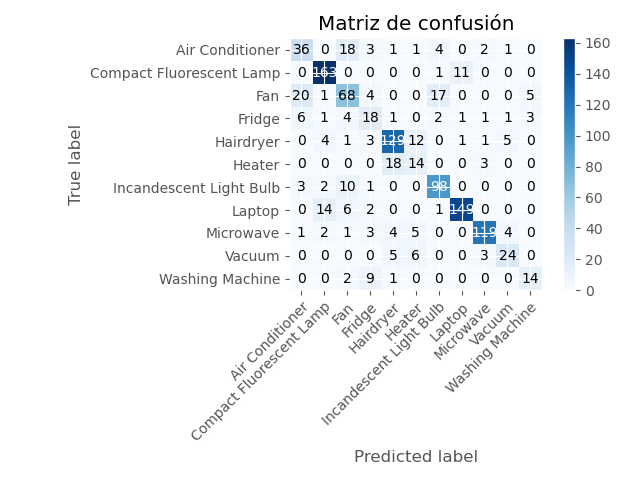

In [46]:
# Performance

print('Clasificador: KNN')
mostrar_performance(accuracies, y_predictions, TIPO)

## Parte 5. Otros clasificadores

Experimentar con algún otro clasificador. 

Repetir lo realizado en la parte 4.

Realizar una tabla resumen de resultados y comparar con el clasificador de K-NN.

In [47]:
# EXPERIMENTAR
clasificador = LogisticRegression()
#caracteristicas = DATOS_IEEE[:,:]
print(caracteristicas)
print(np.asmatrix(caracteristicas).shape)

accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)


[[4.17100000e+01 3.06400000e+01 6.00000000e-01 ... 9.20000000e-01
  8.05156658e-01 5.81155598e-01]
 [3.77200000e+01 2.83000000e+01 5.20000000e-01 ... 8.80000000e-01
  8.13427562e-01 6.00212089e-01]
 [3.80300000e+01 2.91400000e+01 5.10000000e-01 ... 8.40000000e-01
  7.98901853e-01 6.02419143e-01]
 ...
 [2.69700000e+01 2.67700000e+01 5.00000000e-02 ... 1.20000000e-01
  7.61673515e-01 7.55654431e-01]
 [2.59500000e+01 2.57700000e+01 5.00000000e-02 ... 1.20000000e-01
  9.77493209e-01 9.71483622e-01]
 [7.49530000e+02 7.47660000e+02 1.86000000e+00 ... 5.00000000e-02
  5.47936228e-01 5.47876669e-01]]
(1074, 16)


C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Javo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Clasificador: Regresion logistica
Acierto medio = 61.75
Confusion matrix, without normalization
[[ 41   0   0 ...   4   2   0]
 [  0 110   0 ...   0   0   0]
 [ 15   2  62 ...  21   0   0]
 ...
 [  4   3   0 ... 115   3   3]
 [  0   0   0 ...   0  36   0]
 [  1   0  11 ...   5   0   3]]


<IPython.core.display.Javascript object>


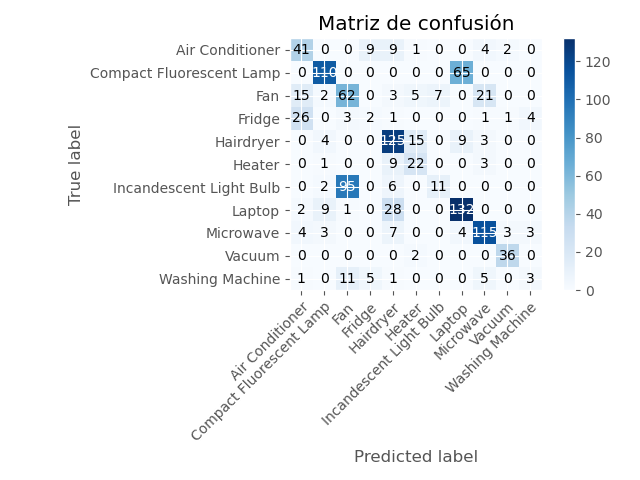

In [48]:
# Performance

print('Clasificador: Regresion logistica')
mostrar_performance(accuracies, y_predictions, TIPO)

In [49]:

# specify model
clasificador = svm.SVC() #defino el objeto modelo


accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)

Clasificador: SVM
Acierto medio = 53.77
Confusion matrix, without normalization
[[ 15   0  12 ...   8   0   0]
 [  0 174   0 ...   0   0   0]
 [  0  62   0 ...   0   0   0]
 ...
 [  0   4   0 ... 125   0   1]
 [  5   0  10 ...  17   0   0]
 [  4   6   1 ...  11   0   2]]


<IPython.core.display.Javascript object>


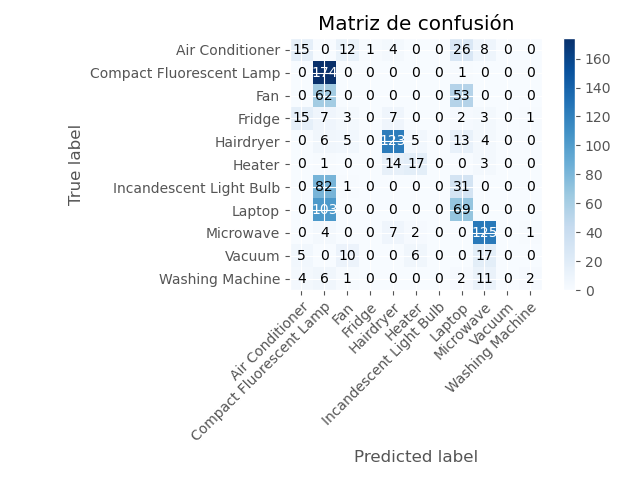

In [50]:
# Performance

print('Clasificador: SVM')
mostrar_performance(accuracies, y_predictions, TIPO)

In [51]:
# EXPERIMENTAR
clasificador = QDA()
#caracteristicas = DATOS_IEEE[:,:]
print(caracteristicas)
print(np.asmatrix(caracteristicas).shape)

accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)

[[4.17100000e+01 3.06400000e+01 6.00000000e-01 ... 9.20000000e-01
  8.05156658e-01 5.81155598e-01]
 [3.77200000e+01 2.83000000e+01 5.20000000e-01 ... 8.80000000e-01
  8.13427562e-01 6.00212089e-01]
 [3.80300000e+01 2.91400000e+01 5.10000000e-01 ... 8.40000000e-01
  7.98901853e-01 6.02419143e-01]
 ...
 [2.69700000e+01 2.67700000e+01 5.00000000e-02 ... 1.20000000e-01
  7.61673515e-01 7.55654431e-01]
 [2.59500000e+01 2.57700000e+01 5.00000000e-02 ... 1.20000000e-01
  9.77493209e-01 9.71483622e-01]
 [7.49530000e+02 7.47660000e+02 1.86000000e+00 ... 5.00000000e-02
  5.47936228e-01 5.47876669e-01]]
(1074, 16)


Clasificador: QDA
Acierto medio = 79.76
Confusion matrix, without normalization
[[ 24   0  16 ...   5   0   0]
 [  0 161   0 ...   0   0   0]
 [  4   0  75 ...   6   0   0]
 ...
 [  1   0   0 ... 137   0   0]
 [  0   0   0 ...  17  16   0]
 [  2   0   1 ...  15   0   7]]


<IPython.core.display.Javascript object>


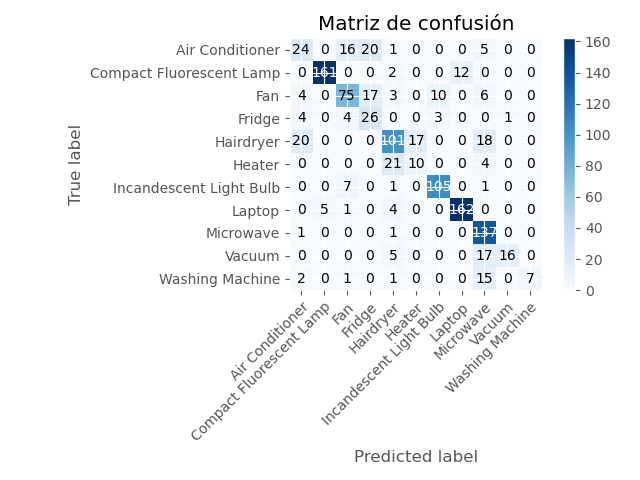

In [56]:
# Performance

print('Clasificador: QDA')
mostrar_performance(accuracies, y_predictions, TIPO)

## Parte 6. Prueba de otras características 

Las características usadas hasta el momento surgen de cálculos sobre las señales que se programaron en la práctica 2.  

También se observó en dicha práctica que el diagrama VI de cada tipo de  electrodoméstico tiene una forma típica. 

En esta parte se usará la forma del diagrama VI como característica para clasificar. 

### 6.1  Función que dados V e I devuelve una imagen del diagrama VI

In [27]:
# VI IMAGE
#
# Adaptado de:  
# [1] Gao, Jingkun, et al. "Plaid: a public dataset of high-resoultion 
# electrical appliance measurements for load identification research: 
# demo abstract." proceedings of the 1st ACM Conference on Embedded 
# Systems for Energy-Efficient Buildings. ACM, 2014.
# 

def get_img_from_VI(V, I, width, hard_threshold=False, para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newV = np.hstack([V, V[0]])
        newI = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # get the size resolution of mesh given width
    d_c = (np.amax(I) - np.amin(I)) / width
    d_v = (np.amax(V) - np.amin(V)) / width
    
    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1  # ok
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1 # why backwards?
    
    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para

### 6.2 Mostrar imágenes  de diagramas 

<IPython.core.display.Javascript object>


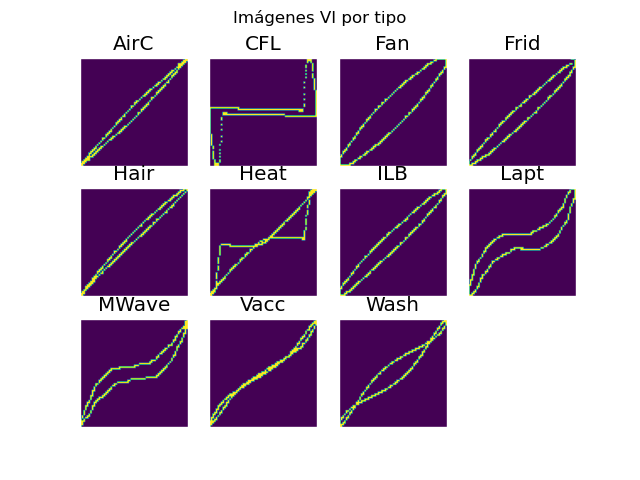

In [33]:
# COMPLETAR
# Mostrar en un subplot las imágenes para los distintos tipos de electrodomésticos
# 
# ancho_imagen_VI = 16
# hard_threshold = True


subplot_rows = 3
subplot_cols = 4
ancho_imagen_VI = 64
hard_th = True


# COMPLETAR código

import random

#Creo la figura, especificando la cantidad de subplots mediante filas y columnas
fig, axs = plt.subplots(subplot_rows, subplot_cols)
fig.suptitle('Imágenes VI por tipo')

# Recorro los subplots
tipo = 0
for i in range(subplot_rows):
    j = 0
    while (j < (subplot_cols)) & (tipo <= 10):
        # Elijo un electrodoméstico al azar dentro del tipo
        elec = random.choice(get_ids_por_tipo(tipo))
        tipo += 1
        # Cargo VI, los promedio y los alineo
        I, V = cargar_VI_por_ciclos_optimizado(get_nombre_archivo(elec), ciclos_a_saltear = 30)
        I, V = get_ciclo_I_V_promedio_alineado(I, V)
        # Obtengo la imagen
        img = get_img_from_VI(V, I, ancho_imagen_VI, hard_th, para=.5)   
        # Plotteo
        axs[i,j].imshow(img)
        axs[i,j].set_title(get_nombre_abreviado(elec))
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
        j+= 1

# Elimino ultima subplot vacía
fig.delaxes(axs[subplot_rows-1,subplot_cols-1])

### 6.3 Clasificar usando la imagen como característica


#### 6.3.1 Calcular las características

Calcular un array **IMG_VI** de tamaño **[cant_electrodomesticos x (ancho_imagen_VI^2)]** donde cada fila es la imagen (pasada a una dimensión recorriendo por filas) del diagrama VI del correspondiente electrodoméstico. 

Usar para las imágenes de VI:
* ancho_imagen_VI = 16
* hard_threshold = True


In [29]:
# COMPLETAR
# Calcular el array IMG_VI  [cant_electrodomesticos x (ancho_imagen_VI^2)] 
# 

ancho_imagen_VI = 32
hard_th = True

ids = get_ids()

# inicializar arrays
IMG_VI = np.empty( (len(ids), ancho_imagen_VI**2))
            
# COMPLETAR código
for elec in ids:
    # Cargo VI, los promedio y los alineo
    print('Calculando {:04d}/{:04d}'.format(elec, len(ids)), end='\r', flush=True)
        
    I, V = cargar_VI_por_ciclos_optimizado(get_nombre_archivo(elec+1), ciclos_a_saltear = 30)
    I, V = get_ciclo_I_V_promedio_alineado(I, V)
    # Obtengo la imagen y la vuelvo fila con .flatten
    imagen = get_img_from_VI(V, I, ancho_imagen_VI, hard_th, para=.5)
    
    IMG_VI[elec] = imagen.flatten()

print(IMG_VI)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 6.3.2 Clasificar y ver performance

In [58]:
# EXPERIMENTAR
# Clasificar con la imagen del diagrama VI como característica

clasificador = RF(n_estimators=2000)

caracteristicas_t = IMG_VI

accuracies, y_predictions = clasificar(clasificador, caracteristicas_t, TIPO, CASA)


Clasificador: RF
Acierto medio = 80.74
Confusion matrix, without normalization
[[ 27   0   5 ...   1   1   2]
 [  0 160   0 ...   0   0   0]
 [  5   0  67 ...   0   0   5]
 ...
 [  0   0   2 ... 130   0   1]
 [  0   0   0 ...   0  38   0]
 [  4   0   2 ...   1   0  15]]


<IPython.core.display.Javascript object>


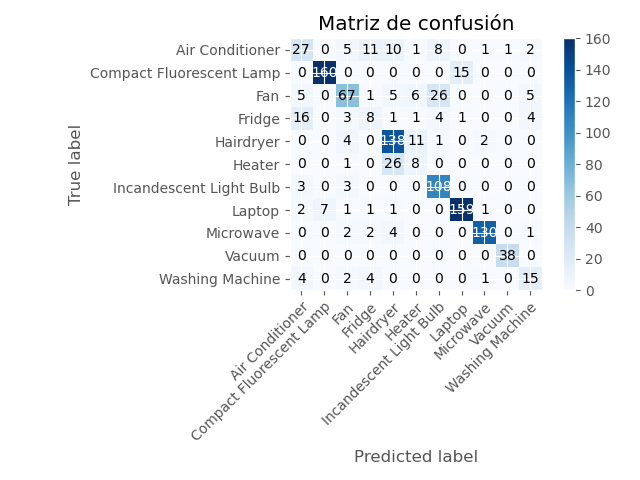

In [60]:
# Performance

print('Clasificador: RF')
mostrar_performance(accuracies, y_predictions, TIPO)

In [61]:
# EXPERIMENTAR
# Clasificar con la imagen del diagrama VI como característica

clasificador = RF(n_estimators=200)

caracteristicas = np.hstack((DATOS_IEEE, IMG_VI))

accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)

Clasificador: RF (Todos los datos)
Acierto medio = 86.61
Confusion matrix, without normalization
[[ 43   0  13 ...   0   1   2]
 [  0 162   0 ...   0   0   0]
 [ 15   0  84 ...   0   0   0]
 ...
 [  0   0   0 ... 131   0   2]
 [  0   0   0 ...   0  38   0]
 [  4   0   1 ...   0   0  15]]


<IPython.core.display.Javascript object>


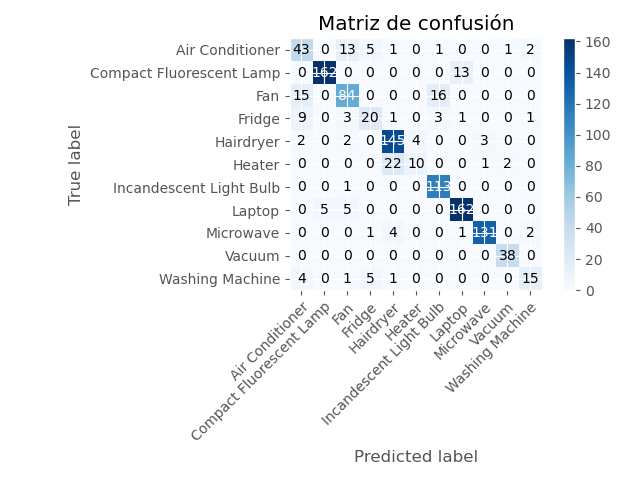

In [62]:
# Performance

print('Clasificador: RF (Todos los datos)')
mostrar_performance(accuracies, y_predictions, TIPO)

#### 6.3.3 Probar con otros tamaños de imagen y/o umbral suave

# EXPERIMENTAR

Podemos ver que el Random Forest tiene la tendencia de ser el mejor modelo a la hora de obtener el mejor "Accuracy". A su vez, podemos notar que usando todos los datos, incluyendo la imagen, es una muy buena idea.

## Parte 7. Competencia 

Buscar la mejor performance medida en terminos del acierto medio. Algunas de las cosas que se pueden probar:
* Distintos clasificadores y parámetros
* Juntar las características calculadas a lo largo de la práctica.
* Introducir nuevas características. 
* Identificar los tipos que se confunden y buscar estrategias para discriminar mejor entre esos tipos



### Importantes premios para los ganadores  !!!!!! 
![alt text](data/won-the-trophy-smiley-emoticon.gif "Vamo' arriba") 




## Parte 8 - Uso de los programas del SDK de WaveForms
Esta parte de la práctica no requiere la realización de código en este notebook.   
Realizar las pruebas con la tarjeta AD2 y los programas de ejemplo del SDK. Comentar y agregar imágenes en el notebook o en  otro documento de los experimentos realizados.

### 8.1 Usar el programa de ejemplo AnalogIn_Record.py para adquirir una sinusoide

#### 8.1.1 Analizar el código. Agregar al código comentarios que indiquen qué se realiza en cada parte.

\# EXPERIMENTAR

#### 8.1.2 Ejecutar el ejemplo

\# EXPERIMENTAR

In [325]:
"""
   DWF Python Example
   Author:  Digilent, Inc.
   Revision:  2018-07-19

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *
from dwfconstants import *
import math
import time
import matplotlib.pyplot as plt
import sys
import numpy

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

#declare ctype variables
hdwf = c_int()
sts = c_byte()
hzAcq = c_double(100)
nSamples = 300
rgdSamples = (c_double*nSamples)()
cAvailable = c_int()
cLost = c_int()
cCorrupted = c_int()
fLost = 0
fCorrupted = 0

#print(DWF version
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

#open device
print("Opening first device")
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

if hdwf.value == hdwfNone.value:
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(str(szerr.value))
    print("failed to open device")
    quit()

'''
Hay una serie de definiciones de tipo y constantes correspondientes en el archivo de inclusión dwf.h. la mayoría de ellos
se utilizan como parámetros. Cuando se abre un dispositivo de hardware, se devuelve un identificador (HDWF), que se utiliza para acceder
y finalmente cierra todas las funciones API del instrumento.

HDWF es la interfaz

'''    
print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_bool(True))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(1))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(2))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_bool(True))

print("Generating sine wave2...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(1), AnalogOutNodeCarrier, c_bool(True))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(1), AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(1), AnalogOutNodeCarrier, c_double(1))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(1), AnalogOutNodeCarrier, c_double(2))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(1), c_bool(True))


#set up acquisition
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(5))
dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(nSamples/hzAcq.value)) # -1 infinite record length

#wait at least 2 seconds for the offset to stabilize
time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

cSamples = 0

while cSamples < nSamples:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
        # Acquisition not yet started.
        continue

    dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))
    
    cSamples += cLost.value

    if cLost.value :
        fLost = 1
    if cCorrupted.value :
        fCorrupted = 1

    if cAvailable.value==0 :
        continue

    if cSamples+cAvailable.value > nSamples :
        cAvailable = c_int(nSamples-cSamples)
    
    dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
    dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 2 data
    cSamples += cAvailable.value
    if (5*cSamples )% nSamples == 0:
        print('% de cSamples', 100*cSamples/nSamples)

dwf.FDwfAnalogOutReset(hdwf, c_int(0))
dwf.FDwfDeviceCloseAll()

print("Recording done")
print('hzAcq', hzAcq)
print('nSamples',nSamples)




if fLost:
    print("Se perdieron las muestras manito! Reducir frequency")
if fCorrupted:
    print("Las muestras se corrumpieron! Reducir frequency")

f = open("record.csv", "w")
for v in rgdSamples:
    f.write("%s\n" % v)
f.close()

'''
for i in range(0,nSamples):
      print(rgdSamples[i])
''' 
    
#plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float))
plt.plot(numpy.fromiter(rgdSamples, dtype = float))
plt.show()




FileNotFoundError: Could not find module 'dwf' (or one of its dependencies). Try using the full path with constructor syntax.

## Parte 9 - Adaptar el programa de la parte 8 al notebook

### 9.1 Completar la funcion de adquisición de un canal

Partiendo del ejemplo AnalogIn_Record.py del SDK de la tarjeta, crear una función que adquiera la señal conectada al primer canal (CH0) del osciloscopio.   

Comentar adecuadamente las partes del código (similar a 8.1.1)

In [ ]:
from ctypes import *
from dwfconstants import *
import math
import time
import matplotlib.pyplot as plt
import sys
import numpy as np


def adquirir_un_canal(cantidad_de_muestras, frecuencia_de_muestreo=25000, 
                     rango_canal_0=10,
                     generar_sinusoide=False):
    '''
    Adquiere la señal conectada al canal ch0 del osciloscopio.
    
    Opcionalmente genera una sinusoide por el primer canal del generador de señales por 
    si se quiere enviar esta señal al osciloscopio.
    
    Devuelve las muestras adquiridas como un array de numpy.
    '''
    
    # COMPLETAR
    
    #Idioma avanzado, leer manual que pasamos al grupo "DIGILENT beyond the theory"

    if sys.platform.startswith("win"):
        dwf = cdll.dwf
    elif sys.platform.startswith("darwin"):
        dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    else:
        dwf = cdll.LoadLibrary("libdwf.so")

    #declare ctype variables
    hdwf = c_int()
    sts = c_byte()
    hzAcq = c_double(frecuencia_de_muestreo)
    nSamples = cantidad_de_muestras
    rgdSamples = (c_double*nSamples)()
    cAvailable = c_int()
    cLost = c_int()
    cCorrupted = c_int()
    fLost = 0
    fCorrupted = 0

    #print(DWF version
    version = create_string_buffer(16)
    dwf.FDwfGetVersion(version)
    print("DWF Version: "+str(version.value))

    #open device
    print("Opening first device")
    dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

    if hdwf.value == hdwfNone.value:
        szerr = create_string_buffer(512)
        dwf.FDwfGetLastErrorMsg(szerr)
        print(str(szerr.value))
        print("failed to open device")
        quit()

    '''
    There are a number of type definitions and corresponding constants in the dwf.h include file. The majority of them
    are used as parameters. When a hardware device is opened, a handle is returned (HDWF), which is used to access
    and finally close in all instrument API functions.

    HDWF es la interfaz

    '''    
    print("Generating sine wave...")
    dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_bool(generar_sinusoide))
    dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
    dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(1))
    dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(2))
    dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_bool(generar_sinusoide))



    #set up acquisition
    dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(rango_canal_0))
    dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
    dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
    dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(nSamples/hzAcq.value)) # -1 infinite record length

    #wait at least 2 seconds for the offset to stabilize
    time.sleep(2)

    print("Starting oscilloscope")
    dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

    cSamples = 0

    while cSamples < nSamples:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
            # Acquisition not yet started.
            continue

        dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))

        cSamples += cLost.value

        if cLost.value :
            fLost = 1
        if cCorrupted.value :
            fCorrupted = 1

        if cAvailable.value==0 :
            continue

        if cSamples+cAvailable.value > nSamples :
            cAvailable = c_int(nSamples-cSamples)

        dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
        #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples, sizeof(c_double)*cSamples), cAvailable) # get channel 2 data
        cSamples += cAvailable.value
        if (5*cSamples )% nSamples == 0:
            print('% de cSamples', 100*cSamples/nSamples)

    dwf.FDwfAnalogOutReset(hdwf, c_int(0))
    dwf.FDwfDeviceCloseAll()

    print("Recording done")
    #print('hzAcq', hzAcq)
    #print('nSamples',nSamples)




    if fLost:
        print("Samples were lost! Reduce frequency")
    if fCorrupted:
        print("Samples could be corrupted! Reduce frequency")

    f = open("record.csv", "w")
    for v in rgdSamples:
        f.write("%s\n" % v)
    f.close()

    #plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float))
    #plt.plot(numpy.fromiter(rgdSamples, dtype = float))
    #plt.show()

    muestras=np.zeros(nSamples)
    
    for i in range(0,nSamples):
        muestras[i]=rgdSamples[i]
    #print('Muestras:',muestras)
    #print('Muestras.shape:', muestras.shape)


        
    return muestras


In [ ]:
# EXPERIMENTAR
# conectar el primer generador de la AD2 al primer canal del osciloscopio de la AD2 y adquirir

cantidad_de_muestras = 50000
generar_sin = True

muestras = adquirir_un_canal(cantidad_de_muestras, generar_sinusoide=generar_sin)
print(muestras.shape)

# guardar a archivo
np.savetxt('ADQUISICION_UN_CANAL.csv', muestras )

#graficar
plt.figure()
plt.plot(muestras,'b.-')
plt.show()

### 9.2 Modificar la función de la parte anterior para poder adquirir de dos canales

Modificar la función de la parte 9.1 para adquirir de los dos canales del osciloscopio.


In [ ]:
def adquirir_dos_canales(cantidad_de_muestras, frecuencia_de_muestreo=25000, 
                         rango_canal_0=10, rango_canal_1=10,
                         generar_sinusoide=False):
    '''
    Adquiere las señales conectadas a los canales ch0 y ch1 del osciloscopio.
    
    Opcionalmente genera una sinusoide por el primer canal del generador de señales por 
    si se quiere enviar esta señal al osciloscopio.
    
    Devuelve las muestras adquiridas como dos arrays de numpy.
    '''
    
    # COMPLETAR
    
    if sys.platform.startswith("win"):
        dwf = cdll.dwf
    elif sys.platform.startswith("darwin"):
        dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    else:
        dwf = cdll.LoadLibrary("libdwf.so")

    #declare ctype variables
    hdwf = c_int()
    sts = c_byte()
    hzAcq = c_double(frecuencia_de_muestreo)
    nSamples = cantidad_de_muestras
    rgdSamples0 = (c_double*nSamples)()
    rgdSamples1 = (c_double*nSamples)()
    cAvailable = c_int()
    cLost = c_int()
    cCorrupted = c_int()
    fLost = 0
    fCorrupted = 0

    #print(DWF version
    version = create_string_buffer(16)
    dwf.FDwfGetVersion(version)
    print("DWF Version: "+str(version.value))

    #open device
    print("Opening first device")
    dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

    if hdwf.value == hdwfNone.value:
        szerr = create_string_buffer(512)
        dwf.FDwfGetLastErrorMsg(szerr)
        print(str(szerr.value))
        print("failed to open device")
        quit()

    '''
    There are a number of type definitions and corresponding constants in the dwf.h include file. The majority of them
    are used as parameters. When a hardware device is opened, a handle is returned (HDWF), which is used to access
    and finally close in all instrument API functions.

    HDWF es la interfaz

    '''    
    print("Generating sine wave...")
    dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_bool(generar_sinusoide))
    dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
    dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(1))
    dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(2))
    dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_bool(generar_sinusoide))
    
    #Opcional mandar señal por el otro canal
    '''
    dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(1), AnalogOutNodeCarrier, c_bool(generar_sinusoide))
    dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(1), AnalogOutNodeCarrier, funcSine)
    dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(1), AnalogOutNodeCarrier, c_double(3))
    dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(1), AnalogOutNodeCarrier, c_double(2))
    dwf.FDwfAnalogOutConfigure(hdwf, c_int(1), c_bool(generar_sinusoide))
    '''

    #set up acquisition
    dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(rango_canal_0))
    dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(1), c_bool(True))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(1), c_double(rango_canal_0))
    
    dwf.FDwfAnalogInAcquisitionModeSet(hdwf, acqmodeRecord)
    dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
    dwf.FDwfAnalogInRecordLengthSet(hdwf, c_double(nSamples/hzAcq.value)) # -1 infinite record length

    #wait at least 2 seconds for the offset to stabilize
    time.sleep(2)

    print("Starting oscilloscope")
    dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

    cSamples = 0

    while cSamples < nSamples:
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        if cSamples == 0 and (sts == DwfStateConfig or sts == DwfStatePrefill or sts == DwfStateArmed) :
            # Acquisition not yet started.
            continue

        dwf.FDwfAnalogInStatusRecord(hdwf, byref(cAvailable), byref(cLost), byref(cCorrupted))

        cSamples += cLost.value

        if cLost.value :
            fLost = 1
        if cCorrupted.value :
            fCorrupted = 1

        if cAvailable.value==0 :
            continue

        if cSamples+cAvailable.value > nSamples :
            cAvailable = c_int(nSamples-cSamples)

        dwf.FDwfAnalogInStatusData(hdwf, c_int(0), byref(rgdSamples0, sizeof(c_double)*cSamples), cAvailable) # get channel 1 data
        dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples1, sizeof(c_double)*cSamples), cAvailable) # get channel 2 data
        cSamples += cAvailable.value
        
        if (5*cSamples )% nSamples == 0:
            print('% de cSamples', 100*cSamples/nSamples)

    dwf.FDwfAnalogOutReset(hdwf, c_int(0))
    dwf.FDwfAnalogOutReset(hdwf, c_int(1))
    dwf.FDwfDeviceCloseAll()

    print("Recording done")

    if fLost:
        print("Samples were lost! Reduce frequency LOL")
    if fCorrupted:
        print("Samples could be corrupted! Reduce frequency bruh")

    f = open("record_ch0.csv", "w")
    for v in rgdSamples0:
        f.write("%s\n" % v)
    f.close()
    
    f = open("record_ch1.csv", "w")
    for v in rgdSamples1:
        f.write("%s\n" % v)
    f.close()


    #plt.plot(numpy.fromiter(rgdSamples0, dtype = float))
    #plt.plot(numpy.fromiter(rgdSamples1, dtype = float))
    #plt.show()

    muestras_ch0=np.zeros(nSamples)
    muestras_ch1=np.zeros(nSamples)
    
    for i in range(0,nSamples):
        muestras_ch0[i]=rgdSamples0[i]
        muestras_ch1[i]=rgdSamples1[i]

    
    
        
    return muestras_ch0, muestras_ch1


In [ ]:
# EXPERIMENTAR 
# conectar el primer generador de la AD2 a los dos canales del osciloscopio de la AD2 y adquirir

cantidad_de_muestras = 50000
generar_sin = True

muestras_ch0, muestras_ch1 = adquirir_dos_canales(cantidad_de_muestras, generar_sinusoide=generar_sin)
print(muestras_ch0.shape, muestras_ch1.shape)


# juntar las muestras en un sólo array de tamaño (cantidad_de_muestras x 2)
muestras = np.vstack((muestras_ch0, muestras_ch1)).T
print(muestras.shape)

# guardar a archivo
np.savetxt('ADQUISICION_DOS_CANALES.csv', muestras )

#graficar
plt.figure()
plt.plot(muestras_ch0,'b', label='ch0')
plt.plot(muestras_ch1,'r', label='ch1')
plt.legend()
plt.show()